In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import os
import sys

## Load data

In [2]:
data_dir = './data'

student_log_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('student_log')]
training_label_path = os.path.join(data_dir, 'training_label.csv')
validation_test_label = os.path.join(data_dir, 'validation_test_label.csv')

dfs = []

for path in student_log_paths:
    temp = pd.read_csv(path)
    dfs.append(temp)
student_df = pd.concat(dfs)

training_label_df = pd.read_csv(training_label_path)
validation_test_label_df = pd.read_csv(validation_test_label)

/Users/chunkit/anaconda3/envs/dlenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Remove duplicates

In [3]:
#student_df = student_df.drop_duplicates(['ITEST_id'])
training_label_df = training_label_df.drop_duplicates(['ITEST_id'])

# normalizing the NumActions using mean normalizing
num_act = student_df['NumActions']
student_df['NumActions'] = (num_act - num_act.mean()) / num_act.std()
num_act = student_df['NumActions']
student_df['NumActions'] = (num_act - num_act.min())/(num_act.max() - num_act.min())

In [4]:
print("student_df.shape:", student_df.shape) 
print("training_label_df.shape:", training_label_df.shape)
print("validation_test_label_df.shape:", validation_test_label_df.shape)

student_df.shape: (942816, 77)
training_label_df.shape: (467, 5)
validation_test_label_df.shape: (172, 4)


In [5]:
skill = student_df.skill.unique()
skill_id = range(len(skill))
skill_id_map = dict(zip(skill, skill_id))

In [6]:
training_label_df.columns

Index(['ITEST_id', 'SchoolId', 'AveCorrect', 'MCAS', 'isSTEM'], dtype='object')

In [7]:
print(np.mean(training_label_df['isSTEM']))

0.2505353319057816


In [8]:
student_specific_columns = ["AveKnow",
                            "AveCarelessness",
                            "AveCorrect",
                            "NumActions",
                            "AveResBored",
                            "AveResEngcon",
                            "AveResConf",
                            "AveResFrust",
                            "AveResOfftask",
                            "AveResGaming"]

In [9]:
required_cols = ['ITEST_id'] + student_specific_columns
student_specific_df = student_df[required_cols].drop_duplicates()

In [10]:
# student_specific_columns += ['MCAS', 'SchoolId']

# Static features

In [11]:
# combined_df = pd.merge(left=training_label_df, right=student_specific_df, how='left', left_on='ITEST_id', right_on='ITEST_id')
combined_df_train = training_label_df.merge(student_specific_df, left_on='ITEST_id', right_on='ITEST_id', how='left')
combined_df_train['AveCorrect'] = combined_df_train['AveCorrect_x']
del combined_df_train['AveCorrect_x']
del combined_df_train['AveCorrect_y']
X_static = combined_df_train[student_specific_columns].values
y_static = combined_df_train['isSTEM'].values
static_features_cols = student_specific_columns

In [12]:
combined_df_train[student_specific_columns].head()

,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,AveResConf,AveResFrust,AveResOfftask,AveResGaming
0,0.185138,0.099734,0.438492,0.164321,0.277149,0.644744,0.098078,0.162771,0.213378,0.005554
1,0.142031,0.069297,0.348837,0.041571,0.330226,0.551367,0.122658,0.095420,0.348090,0.036900
2,0.459813,0.202787,0.686391,0.054664,0.260426,0.650769,0.059971,0.061834,0.296286,0.010954
3,0.255164,0.158848,0.379658,0.324386,0.222796,0.650079,0.069987,0.164347,0.153147,0.236800
4,0.071909,0.046183,0.305785,0.038953,0.326384,0.653445,0.125325,0.094714,0.451467,0.016241


In [13]:
combined_df_test = pd.merge(left=validation_test_label_df, right=student_specific_df, how='left')
X_target = combined_df_test[student_specific_columns].values

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)

stat = pca.fit_transform(X_static)
print(stat.shape)
print(pca.explained_variance_ratio_)

(467, 7)
[0.56003693 0.29352088 0.05218283 0.03514465 0.02493799 0.01925573
 0.00815808]


# Import model of DKT
If you want to change the model with different regularization parameters
Simply change
```python
network_config['lambda_o']
network_config['lambda_w1']
network_config['lambda_w2']
```
to the desired value

---
To use the original DKT model without any regularization:
```python
network_config['lambda_o'] = 0.0
network_config['lambda_w1'] = 0.0
network_config['lambda_w2'] = 0.0
```

To use the original DKT model with regularization:
```python
network_config['lambda_o'] = 0.1
network_config['lambda_w1'] = 0.3
network_config['lambda_w2'] = 3.0
```

# Obtain student's DKT feature

# DKT feature 

In [15]:
students_dk_df = pd.read_csv('./data/students_knowledge_states_dkt.csv')
combined_df = pd.merge(left=student_specific_df, right=students_dk_df, how='left')
train_df = training_label_df.merge(combined_df, left_on='ITEST_id', right_on='ITEST_id', how='left')
test_df = validation_test_label_df.merge(combined_df, left_on='ITEST_id', right_on='ITEST_id', how='left')
train_df['AveCorrect'] = train_df['AveCorrect_x']
del train_df['AveCorrect_x']
del train_df['AveCorrect_y']
test_df['AveCorrect'] = test_df['AveCorrect_x']
del test_df['AveCorrect_x']
del test_df['AveCorrect_y']

In [16]:
dkt_features_cols = list(train_df.columns.drop(['ITEST_id', 'isSTEM', 'SchoolId', 'MCAS']))
kt_cols = ['kt_{}'.format(i) for i in range(102)]

# DKT only 
X_dkt = train_df[kt_cols].values
y_dkt = train_df['isSTEM'].values

# DKT + student profile
X_dktsp = train_df[dkt_features_cols].values
y_dktsp = train_df['isSTEM'].values
#X_test_dkt = test_df[features_cols].values

In [17]:
X_dkt

array([[0.05622318, 0.50651717, 0.36671746, ..., 0.8257494 , 0.72340071,
        0.36694288],
       [0.07800379, 0.3403666 , 0.33121639, ..., 0.58999926, 0.60349226,
        0.30993772],
       [0.03244137, 0.68556792, 0.32228327, ..., 0.87292838, 0.79397225,
        0.38784996],
       ...,
       [0.02609839, 0.63014001, 0.53425163, ..., 0.6567539 , 0.40414989,
        0.26455277],
       [0.10431756, 0.19257784, 0.16598728, ..., 0.48119059, 0.51756734,
        0.28647605],
       [0.06014723, 0.51490551, 0.34661227, ..., 0.61904436, 0.68885845,
        0.42427588]])

# DKT+ feature 

In [18]:
students_dk_df = pd.read_csv('./data/students_knowledge_states_dktp.csv')
combined_df = pd.merge(left=student_specific_df, right=students_dk_df, how='left')
train_df = training_label_df.merge(combined_df, left_on='ITEST_id', right_on='ITEST_id', how='left')
#test_df = validation_test_label_df.merge(combined_df, left_on='ITEST_id', right_on='ITEST_id', how='left')
train_df['AveCorrect'] = train_df['AveCorrect_x']
del train_df['AveCorrect_x']
del train_df['AveCorrect_y']
#test_df['AveCorrect'] = test_df['AveCorrect_x']
#del test_df['AveCorrect_x']
#del test_df['AveCorrect_y']

In [19]:
dktp_features_cols = list(train_df.columns.drop(['ITEST_id', 'isSTEM', 'SchoolId', 'MCAS']))
kt_cols = ['kt_{}'.format(i) for i in range(102)]

# DKT only 
X_dktp = train_df[kt_cols].values
y_dktp = train_df['isSTEM'].values

# DKT + student profile
X_dktpsp = train_df[dkt_features_cols].values
y_dktpsp = train_df['isSTEM'].values
#X_test_dkt = test_df[features_cols].values

In [20]:
X_dktp

array([[0.00492973, 0.85605657, 0.55900872, ..., 0.80466402, 0.88031369,
        0.17737298],
       [0.00965314, 0.52239507, 0.4509998 , ..., 0.80424255, 0.8802858 ,
        0.17701891],
       [0.00324686, 0.31928211, 0.18094359, ..., 0.80460984, 0.8801676 ,
        0.17669304],
       ...,
       [0.00155248, 0.56527251, 0.38097528, ..., 0.80480438, 0.88036895,
        0.1769518 ],
       [0.00495684, 0.16182527, 0.11950365, ..., 0.80452287, 0.88016236,
        0.17656463],
       [0.01448976, 0.58506435, 0.26544836, ..., 0.80465317, 0.88039899,
        0.17671247]])

# Training the static machine learning model

In [21]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    auc, 
    roc_curve,
    mean_squared_error,
    make_scorer, 
    accuracy_score, 
    precision_score, 
    recall_score,
    average_precision_score, 
    f1_score)

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from imblearn.over_sampling import (
    RandomOverSampler,
    ADASYN,
    SMOTE,
)

from imblearn.combine import (
    SMOTEENN,
    SMOTETomek,
)

CV_OBJ = StratifiedKFold(n_splits=5)

In [22]:
lr_param_grid = {
    'C': [1e-3, 1e-2, 1e-1, 1, 10.0, 100.0],
    'penalty': ['l1', 'l2']
    
}

In [23]:
svm_param_grid = {
    'C': [1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0], 
#     'gamma': ['auto',0.001, 0.003, 0.01, 0.03, 0.1, 0.3], 
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}


In [24]:
gbdt_param_grid = {
   # 'n_estimators': [600, 700, 8000], 
    'n_estimators': [10, 25, 50, 120, 300], 
    'max_depth': [2,3,5,8],
    'min_samples_leaf': [1,2,5,10]
}

In [25]:
import itertools
mlp_layer_search_list = list(itertools.product([16, 64, 128, 256]))
mlp_layer_search_list += list(itertools.product([16, 64, 128, 256], [16, 64, 128, 256]))
mlp_layer_search_list += list(itertools.product([16, 64, 128, 256], [16, 64, 128, 256], [16, 64, 128, 256]))
mlp_param_grid = {
    'hidden_layer_sizes': mlp_layer_search_list,
    'early_stopping': [True]
}

In [26]:
lda_param_grid = {
#     'solver':['svd', 'lsqr', 'eigen'], 
#     'solver': ['svd'],
    'n_components': [None, 1],
#     'tol':[1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1.0]
}

qda_param_grid = {'reg_param': [0, 0.1, 0.2, 0.3], 'tol':[1e-10, 3e-10, 1e-9, 3e-9, 1e-8, 3e-8], 
                  'priors':[None, [0.75, 0.25]]}

## Define customized scorer 

In [27]:
from sklearn.metrics import make_scorer
def auc_score(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    auc_ = auc(fpr, tpr)
    return auc_
auc_scorer = make_scorer(auc_score, greater_is_better = True)

In [28]:
def rmse_score(y_true, y_pred):
    rmse_ = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_
rmse_scorer = make_scorer(rmse_score, greater_is_better = False)

In [29]:
#Evaluation metric of ASSISTments DM Competition
def admc_score(y_true, y_pred):
    auc_ = auc_score(y_true, y_pred)
    rmse_ = rmse_score(y_true, y_pred)
    
    return auc_ + (1 - rmse_)

admc_scorer = make_scorer(admc_score, greater_is_better=True)

#  Experiment

## Define lists and dictionaries

In [30]:
algorithm_dict = {
    'LR': LogisticRegression(), 
#     'SVM': SVC(probability=True), 
    #'ANN':MLPClassifier(), 
    'GBDT': GradientBoostingClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    #'QDA': QuadraticDiscriminantAnalysis() 
}



feature_list = ['SP','DKT','DKT+', 'DKT/SP', 'DKT+/SP']

param_dict = {
    'LR': lr_param_grid, 
    'SVM': svm_param_grid, 
    'ANN': mlp_param_grid, 
    'GBDT': gbdt_param_grid,
    'LDA': lda_param_grid, 
    'QDA': qda_param_grid
}

scoring_metrics = {   
    #'Accuracy': accuracy_score, 
    #'Precision': precision_score, 
    #'Recall': recall_score,
    'AP':average_precision_score, #'average_precision'
    #'F1': f1_score,
    'AUC': auc_score, #'roc_auc' ,
    'RMSE': rmse_score,
    'AUC+(1-RMSE)':admc_score #admc_scorer
}

In [31]:
RANDOM_STATE = 12

In [32]:
from sklearn.metrics import roc_auc_score
y_true = np.random.randint(2, size=10)
y_pred = np.random.randint(2, size=10)
print(roc_auc_score(y_true, y_pred))

0.5


In [33]:
auc_score(y_true, y_pred)

0.5

## Feature selection

In [34]:

from sklearn.feature_selection import RFECV
from matplotlib import pyplot as plt
'''
Use RFE to select optimal number of features from the 
feature_set(static, DKT， DKT+)
return the reduced X and output the selected feature names,
the cv result for each number of feature is also ploted

params: 
algorithm: name of classifier used for RFE
feature_set: static, DKT or DKT+
n_fold: number of folds for CV

return : 
X_new: reduced data set with optimal number of features
'''

from sklearn.model_selection import StratifiedKFold
def feature_selection(X, y, algorithm, feature_set, n_fold):
    
    #declear  rfe object
    
    rfecv = RFECV(estimator=algorithm_dict[algorithm], 
                      step=1, 
                      cv=CV_OBJ,
                      scoring=admc_scorer,
                       verbose=0)
    
    #fit and transform input data
    
#     X_new = rfecv.fit_transform(X, y)
    rfecv.fit(X, y)
    X_new = rfecv.transform(X)
#     print(rfecv.support_)
    print("Optimal number of features : {}".format(rfecv.n_features_))
    
    # Plot number of features VS. cross-validation scores
    fig, ax = plt.subplots()
    ax.set_ylim([0.8,1.25])
    plt.xlabel("Number of features selected")
    plt.ylabel("Combined score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.title("Feature Selection Result of {}-{}".format(algorithm, feature_set))
    plt.show()
    
    #find the selected features' names
    features_cols =[]
    if(feature_set == 'SP'):
        features_cols = static_features_cols
    elif(feature_set == 'DKT'):
        features_cols = kt_cols
    elif(feature_set == 'DKT+'):
        features_cols = kt_cols
    elif(feature_set == 'DKT&SP'):
        features_cols = dkt_features_cols
    elif(feature_set == 'DKT+&SP'):
        features_cols = dktp_features_cols
    
    print()
    #get the indices of selected features
    indices = rfecv.get_support(indices=True)
    
    selected_feas = []
#     print(features_cols)
    for idx in indices:
        selected_feas.append(features_cols[idx])
    
    print('Selected Features: \n')
    print(selected_feas)
    
    
    
    #return X_new
    return X_new


In [35]:

from sklearn.feature_selection import RFECV
from matplotlib import pyplot as plt
'''
Use RFE to select optimal number of features from the 
feature_set(static, DKT， DKT+)
return the reduced X and output the selected feature names,
the cv result for each number of feature is also ploted

params: 
algorithm: name of classifier used for RFE
feature_set: static, DKT or DKT+
n_fold: number of folds for CV

return : 
X_new: reduced data set with optimal number of features
'''
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFpr, f_classif
from sklearn.model_selection import StratifiedKFold
def feature_selection_kbest(X, y, algorithm, feature_set, n_fold):
    
    #declear  rfe object
    
    selector = SelectKBest(f_classif, k=10)   
    X_new = selector.fit_transform(X, y)

    
    #find the selected features' names
    features_cols =[]
    if(feature_set == 'SP'):
        features_cols = static_features_cols
    elif(feature_set == 'DKT'):
        features_cols = kt_cols
    elif(feature_set == 'DKT+'):
        features_cols = kt_cols
    elif(feature_set == 'DKT&SP'):
        features_cols = dkt_features_cols
    elif(feature_set == 'DKT+&SP'):
        features_cols = dktp_features_cols
    
    print()
    #get the indices of selected features
    indices = selector.get_support(indices=True)
    
    selected_feas = []
    for idx in indices:
        selected_feas.append(features_cols[idx])
    
    print('Selected Features: \n')
    print(selected_feas)
    
    
    
    #return X_new
    return X_new


In [36]:

# coding: utf-8

# # Implementation of functions that adds random Gaussian noise to training data  so as to reduce overfitting 

# In[27]:


import numpy as np
from sklearn.model_selection import StratifiedKFold
'''
Add gaussian noise to each feature of every sample in X.

Params:
X: input numpy nd array data
y: input numpy nd array label
num: how many more noise-processed data to be added. 
If num = n, then the returned data will be (n+1) times as
many rows as X
std: the standard deviation of the Gaussian noise


Return:
new data with noised data added and shuffled.
'''
def add_noise(X, y, num, std):
    
    X_new = X
    y_new = y
    for i in range(0, num, 1):
        noise = np.random.normal(0,std, X.shape)
        X_temp = X + noise
        X_new = np.concatenate((X_new, X_temp))
        
        y_new = np.concatenate((y_new, y))
        
    perm = np.random.permutation(X_new.shape[0])
    X_new = X_new[perm]
    y_new = y_new[perm]
    return X_new, y_new






# ## Re-define Cross-Validation with noise

# In[33]:


'''
cross validate the input estimator using stratified  n_fold shuffle split,
return the mean and std of each metric in dictionary format

params:
scoring_dcit: with metric name (e.g. 'AUC') as keys and 
callable scoring function as values, which has the signature
of (y_true, y_pred) and return scores

std: standard deviation of the Gaussian noise

return:
score_dict: with metric name (e.g. 'AUC') as keys and 
mean +/- 2*std string as values
'''

def multi_metrics_noise_cv(estimator, X, y, scoring_dict, std, n_fold = 5, oversampling=None):
    
   
    # dictionary storing the result of the cross-validation
    train_score_result_dict =  {metric:[] for metric in scoring_dict}
    test_score_result_dict =  {metric:[] for metric in scoring_dict}
    
    # define the object for corss-validation
    #sss = StratifiedShuffleSplit(n_splits=n_fold, random_state=RANDOM_STATE)
    sss = StratifiedKFold(n_splits=n_fold)
    # performing the cross-validation
    
    for train_index, test_index in sss.split(X, y):

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        
        #print("Train pos percentage: {}, Test pos percentage: {}".format(np.mean(y_train), np.mean(y_test)))
        
        sampler = None
        # performing the oversampling.
        if oversampling == 'ros':
            sampler = RandomOverSampler(random_state=42)
        elif oversampling == 'adasyn':
            sampler = ADASYN(random_state=42)
        elif oversampling == 'smote':
            sampler = SMOTE(random_state=42)
        elif oversampling == 'smoteenn':
            sampler = SMOTEENN(random_state=42)
        elif oversampling == 'smotetomek':
            sampler = SMOTETomek(random_state=42)
        
        if sampler is not None:
            X_train, y_train = sampler.fit_sample(X_train, y_train)
        
        
        #Add noise to training data
        
        X_train, y_train = add_noise(X=X_train, y=y_train, num=19, std = std)
        # train the model
        estimator.fit(X_train, y_train)
        
        
        #evaluate the model
        
      
        y_pred_train = [proba[1] for proba in estimator.predict_proba(X_train)]
        y_pred_test = [proba[1] for proba in estimator.predict_proba(X_test)]
        
        
        
        #print(y_pred)
        for metric in scoring_dict:
            train_score = scoring_dict[metric](y_train, y_pred_train)
            test_score = scoring_dict[metric](y_test, y_pred_test)
        
            train_score_result_dict[metric].append(train_score)
            test_score_result_dict[metric].append(test_score)
        
        
    # transforming the result

        
    for metric in scoring_dict:
        train_mean = np.mean(train_score_result_dict[metric])
        train_std = np.std(train_score_result_dict[metric])
        
        test_mean = np.mean(test_score_result_dict[metric])
        test_std = np.std(test_score_result_dict[metric])
        
        train_val_str = "{:.3f} $\pm$ {:.3f}".format(train_mean, 2*train_std)
        test_val_str = "{:.3f} $\pm$ {:.3f}".format(test_mean, 2*test_std)
        
        
        train_score_result_dict[metric] = train_val_str
        test_score_result_dict[metric] =  test_val_str
        test_score = test_mean
    
    return train_score_result_dict, test_score_result_dict, test_score


# ## Re-define GridSearchCV with noise-adding functionality

# In[34]:


from sklearn.model_selection import ParameterGrid

def noise_grid_search_cv(X, y, estimator, param_grid, scoring_dict, cv=5):
    param_list = list(ParameterGrid(param_grid))
    
    best_score = 0
    best_train_score_dict={} 
    best_test_score_dict = {}
    best_param = {}
    std_list = [0.025]
    best_std = 0
    
    for param in param_list:
        for std in std_list:
            print("Test on {}, std: {}".format(param, std))
            estimator.set_params(**param)
           
            train_score_dict, test_score_dict, test_score = multi_metrics_noise_cv(X=X,y=y, estimator=estimator, n_fold=cv, scoring_dict = scoring_dict, std =std )
            
            if(test_score>best_score):
                best_std = std
                best_train_score_dict= train_score_dict 
                best_test_score_dict = test_score_dict
                best_param = param
    best_param['noise_std'] = best_std
    return best_train_score_dict, best_test_score_dict, best_param



In [37]:
def multi_metrics_cv(estimator, X, y, params,scoring_dict,n_fold = 5):
    
   
    # dictionary storing the result of the cross-validation
    train_score_result_dict =  {metric:[] for metric in scoring_dict}
    test_score_result_dict =  {metric:[] for metric in scoring_dict}
    
    # define the object for corss-validation
    #sss = StratifiedShuffleSplit(n_splits=n_fold, random_state=RANDOM_STATE)
    sss = StratifiedKFold(n_splits=n_fold)
    # performing the cross-validation
    
    estimator.set_params(**params)
    for train_index, test_index in sss.split(X, y):

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # train the model
        estimator.fit(X_train, y_train)
        
        
        #evaluate the model
        y_pred_train = [proba[1] for proba in estimator.predict_proba(X_train)]
        y_pred_test = [proba[1] for proba in estimator.predict_proba(X_test)]
#         print('='*12)
#         print('train:')
#         plt.hist(y_pred_train, bins=50, range=(0.0,1.0))
#         print('='*5)
#         print('test:')
#         plt.hist(y_pred_test, bins=50, range=(0.0,1.0))
#         print('='*12)

        
        
        
        #print(y_pred)
        for metric in scoring_dict:
            train_score = scoring_dict[metric](y_train, y_pred_train)
            test_score = scoring_dict[metric](y_test, y_pred_test)
        
            train_score_result_dict[metric].append(train_score)
            test_score_result_dict[metric].append(test_score)
     
    # transforming the result

        
    for metric in scoring_dict:
        train_mean = np.mean(train_score_result_dict[metric])
        train_std = np.std(train_score_result_dict[metric])
        
        test_mean = np.mean(test_score_result_dict[metric])
        test_std = np.std(test_score_result_dict[metric])
        
        train_val_str = "{:.3f} $\pm$ {:.3f}".format(train_mean, 2*train_std)
        test_val_str = "{:.3f} $\pm$ {:.3f}".format(test_mean, 2*test_std)
        
        
        train_score_result_dict[metric] = train_val_str
        test_score_result_dict[metric] =  test_val_str
        test_score = test_mean
        
    print('='*30)
    print('params:', params)
    print('train result:', train_score_result_dict)
    print('test result:', test_score_result_dict)
    print('='*30)
    
    return train_score_result_dict, test_score_result_dict


##  Perform parameter search and test on each feature set on 4 clfs 


In [38]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
'''
Do parameter search and get experimental result on given feature (string)
return dictionaries containing the scores of each clf

Params:
    feature: 'static', 'DKT', 'DKT+'
    scoring_dict: with metric name (e.g. 'AUC') as keys and 
        callable scoring function as values, which has the signature
        of (y_true, y_pred) and return scores
'''
def test_feature(feature, scoring_dict,oversampling=None):
    
    train_res_dict = {metric:[] for metric in scoring_dict} 
    train_res_dict['name'] = []
    
    test_res_dict = {metric:[] for metric in scoring_dict} 
    test_res_dict['name'] = []
    best_param_dict = {
        'name': [],
        'params': []
    }
    
    if feature == 'SP':
        X_train = X_static
        y_train = y_static
    elif feature == 'DKT':
        X_train = X_dkt
        y_train = y_dkt
    elif feature == 'DKT+':
        X_train = X_dktp
        y_train = y_dktp
    elif feature == 'DKT&SP':
        X_train = X_dktsp
        y_train = y_dktsp
    elif feature == 'DKT+&SP':
        X_train = X_dktpsp
        y_train = y_dktpsp
    else:
        print('Please select correct feature!')
        return 
        
    pca = decomposition.PCA(n_components=0.99)
    
#     X_train = pca.fit_transform(X_train)
#     print(X_train.shape)
#     print(pca.explained_variance_ratio_)
    
    for algorithm in algorithm_dict:
        print(algorithm)
#         X_train_noise, y_train_noise = add_noise(X=X_train, y=y_train, num=19, std = 0.1)
        X_new = feature_selection(X=X_train, y=y_train, algorithm=algorithm, feature_set=feature, n_fold=5)
#         X_new = feature_selection_kbest(X=X_train, y=y_train, algorithm=algorithm, feature_set=feature, n_fold=5)
#         X_new = X_train
        
        clf = GridSearchCV(
            estimator=algorithm_dict[algorithm],
            param_grid=param_dict[algorithm],
            scoring=admc_scorer,
            cv=CV_OBJ,
            verbose=0,
            return_train_score=True
        )
        
        clf.fit(X_new, y_train)
        
        best_param = clf.best_params_
        
        
        train_score_dict, test_score_dict =  multi_metrics_cv(X=X_new, y=y_train, 
                                                             estimator=algorithm_dict[algorithm],
                                                             params = best_param, 
                                                             scoring_dict =scoring_dict, n_fold=5)
        
        '''
        train_score_dict, test_score_dict, best_param = noise_grid_search_cv(X=X_new, y=y_train, 
                                                                             estimator=algorithm_dict[algorithm],
                                                                             param_grid=param_dict[algorithm], 
                                                                             scoring_dict =scoring_dict, cv=5)
        '''
        # Append the score into dictionaries
        train_res_dict['name'].append(algorithm)
        test_res_dict['name'].append(algorithm)
        best_param_dict['name'].append(algorithm)
        best_param_dict['params'].append(best_param)
        
        '''
        for metric in scoring_metrics:
            train_mean = results['mean_train_{:s}'.format(metric)][best_index]
            train_std = results['std_train_{:s}'.format(metric)][best_index]
            
            
            #print("train_mean: {}".format(train_mean))
            train_val_str = "{:.3f} $\pm$ {:.3f}".format(train_mean, 2*train_std)
            train_res_dict[metric].append(train_val_str)
            
            test_mean = results['mean_test_{:s}'.format(metric)][best_index]
            test_std = results['std_test_{:s}'.format(metric)][best_index]
            test_val_str = "{:.3f} $\pm$ {:.3f}".format(test_mean, 2*test_std)
            test_res_dict[metric].append(test_val_str)

        '''
        #print("STD: ")
        #print(best_param['noise_std'])
        for score in train_score_dict:
            train_res_dict[score].append(train_score_dict[score])
            test_res_dict[score].append(test_score_dict[score])
        
    return train_res_dict, test_res_dict, best_param_dict

In [39]:
import warnings
warnings.filterwarnings('ignore')

## Write result tabel of approach 2 to csv files

In [40]:
RANDOM_STATE = 12

DKT&SP
LR
Optimal number of features : 12


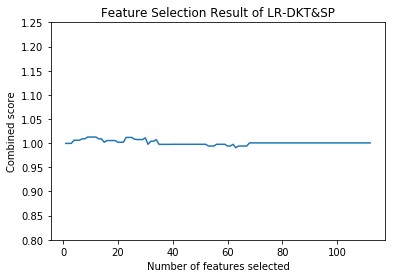


Selected Features: 

['AveKnow', 'AveCarelessness', 'kt_10', 'kt_100', 'kt_15', 'kt_17', 'kt_31', 'kt_51', 'kt_68', 'kt_87', 'kt_95', 'AveCorrect']
params: {'C': 100.0, 'penalty': 'l1'}
train result: {'AP': '0.467 $\\pm$ 0.037', 'AUC': '0.722 $\\pm$ 0.022', 'RMSE': '0.407 $\\pm$ 0.008', 'AUC+(1-RMSE)': '1.316 $\\pm$ 0.030'}
test result: {'AP': '0.417 $\\pm$ 0.138', 'AUC': '0.683 $\\pm$ 0.104', 'RMSE': '0.421 $\\pm$ 0.032', 'AUC+(1-RMSE)': '1.262 $\\pm$ 0.135'}
GBDT
Optimal number of features : 96


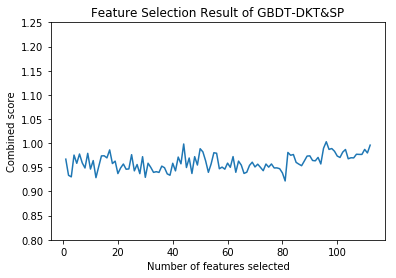


Selected Features: 

['AveKnow', 'AveCarelessness', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask', 'AveResGaming', 'kt_0', 'kt_1', 'kt_10', 'kt_100', 'kt_101', 'kt_11', 'kt_12', 'kt_14', 'kt_15', 'kt_16', 'kt_17', 'kt_19', 'kt_20', 'kt_21', 'kt_22', 'kt_23', 'kt_24', 'kt_25', 'kt_28', 'kt_29', 'kt_3', 'kt_31', 'kt_32', 'kt_33', 'kt_34', 'kt_36', 'kt_37', 'kt_38', 'kt_39', 'kt_4', 'kt_40', 'kt_41', 'kt_42', 'kt_43', 'kt_44', 'kt_45', 'kt_47', 'kt_49', 'kt_50', 'kt_53', 'kt_54', 'kt_55', 'kt_57', 'kt_58', 'kt_59', 'kt_6', 'kt_60', 'kt_61', 'kt_62', 'kt_63', 'kt_64', 'kt_65', 'kt_66', 'kt_67', 'kt_68', 'kt_69', 'kt_70', 'kt_71', 'kt_73', 'kt_74', 'kt_76', 'kt_77', 'kt_78', 'kt_79', 'kt_8', 'kt_80', 'kt_81', 'kt_82', 'kt_83', 'kt_84', 'kt_85', 'kt_86', 'kt_87', 'kt_88', 'kt_89', 'kt_9', 'kt_90', 'kt_91', 'kt_92', 'kt_93', 'kt_94', 'kt_95', 'kt_96', 'kt_97', 'kt_98', 'kt_99', 'AveCorrect']
params: {'max_depth': 8, 'min_samples_leaf': 2, 'n_estima

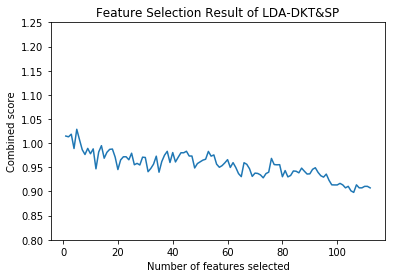


Selected Features: 

['AveCarelessness', 'kt_100', 'kt_17', 'kt_31', 'kt_93']
params: {'n_components': None}
train result: {'AP': '0.455 $\\pm$ 0.037', 'AUC': '0.700 $\\pm$ 0.023', 'RMSE': '0.411 $\\pm$ 0.007', 'AUC+(1-RMSE)': '1.290 $\\pm$ 0.030'}
test result: {'AP': '0.448 $\\pm$ 0.139', 'AUC': '0.685 $\\pm$ 0.089', 'RMSE': '0.418 $\\pm$ 0.028', 'AUC+(1-RMSE)': '1.267 $\\pm$ 0.118'}
DKT+&SP
LR
Optimal number of features : 5


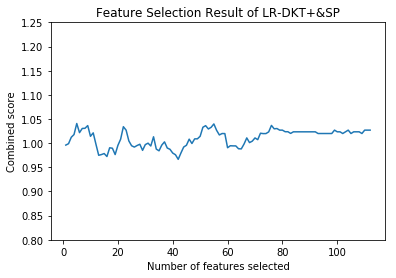


Selected Features: 

['kt_0', 'kt_61', 'kt_78', 'kt_80', 'kt_88']
params: {'C': 100.0, 'penalty': 'l1'}
train result: {'AP': '0.421 $\\pm$ 0.017', 'AUC': '0.623 $\\pm$ 0.018', 'RMSE': '0.418 $\\pm$ 0.002', 'AUC+(1-RMSE)': '1.204 $\\pm$ 0.018'}
test result: {'AP': '0.400 $\\pm$ 0.072', 'AUC': '0.604 $\\pm$ 0.072', 'RMSE': '0.423 $\\pm$ 0.007', 'AUC+(1-RMSE)': '1.181 $\\pm$ 0.070'}
GBDT
Optimal number of features : 96


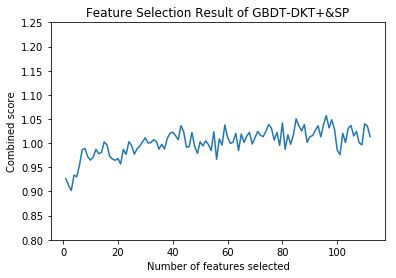


Selected Features: 

['AveKnow', 'AveCarelessness', 'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf', 'AveResFrust', 'AveResOfftask', 'AveResGaming', 'kt_0', 'kt_1', 'kt_10', 'kt_100', 'kt_101', 'kt_11', 'kt_12', 'kt_14', 'kt_15', 'kt_16', 'kt_17', 'kt_18', 'kt_19', 'kt_2', 'kt_20', 'kt_21', 'kt_22', 'kt_23', 'kt_24', 'kt_25', 'kt_26', 'kt_27', 'kt_28', 'kt_29', 'kt_30', 'kt_31', 'kt_32', 'kt_33', 'kt_34', 'kt_36', 'kt_37', 'kt_38', 'kt_39', 'kt_4', 'kt_41', 'kt_42', 'kt_43', 'kt_44', 'kt_45', 'kt_47', 'kt_48', 'kt_49', 'kt_5', 'kt_50', 'kt_51', 'kt_52', 'kt_53', 'kt_57', 'kt_58', 'kt_59', 'kt_60', 'kt_63', 'kt_64', 'kt_65', 'kt_66', 'kt_67', 'kt_68', 'kt_7', 'kt_70', 'kt_71', 'kt_72', 'kt_73', 'kt_74', 'kt_77', 'kt_78', 'kt_79', 'kt_8', 'kt_82', 'kt_83', 'kt_84', 'kt_85', 'kt_86', 'kt_87', 'kt_88', 'kt_89', 'kt_9', 'kt_90', 'kt_91', 'kt_92', 'kt_93', 'kt_94', 'kt_95', 'kt_96', 'kt_97', 'kt_98', 'kt_99', 'AveCorrect']
params: {'max_depth': 3, 'min_samples_leaf': 5, 'n_estimat

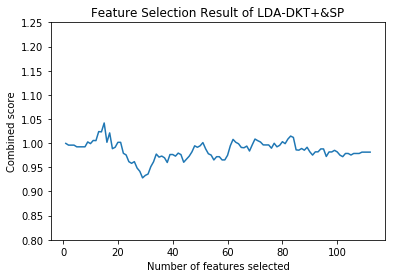


Selected Features: 

['kt_100', 'kt_101', 'kt_28', 'kt_61', 'kt_74', 'kt_78', 'kt_80', 'kt_86', 'kt_93', 'kt_94', 'kt_95', 'kt_96', 'kt_97', 'kt_98', 'kt_99']
params: {'n_components': None}
train result: {'AP': '0.452 $\\pm$ 0.042', 'AUC': '0.682 $\\pm$ 0.015', 'RMSE': '0.412 $\\pm$ 0.005', 'AUC+(1-RMSE)': '1.270 $\\pm$ 0.020'}
test result: {'AP': '0.403 $\\pm$ 0.173', 'AUC': '0.629 $\\pm$ 0.123', 'RMSE': '0.426 $\\pm$ 0.028', 'AUC+(1-RMSE)': '1.203 $\\pm$ 0.148'}
['AP', 'AUC', 'AUC+(1-RMSE)', 'RMSE', 'model']
Train Score


,model,AP,AUC,AUC+(1-RMSE),RMSE
1,GBDT-DKT&SP,1.000 $\pm$ 0.000,1.000 $\pm$ 0.000,2.000 $\pm$ 0.000,0.000 $\pm$ 0.000
1,GBDT-DKT+&SP,1.000 $\pm$ 0.000,1.000 $\pm$ 0.000,1.905 $\pm$ 0.017,0.095 $\pm$ 0.017
2,LDA-DKT&SP,0.455 $\pm$ 0.037,0.700 $\pm$ 0.023,1.290 $\pm$ 0.030,0.411 $\pm$ 0.007
2,LDA-DKT+&SP,0.452 $\pm$ 0.042,0.682 $\pm$ 0.015,1.270 $\pm$ 0.020,0.412 $\pm$ 0.005
0,LR-DKT&SP,0.467 $\pm$ 0.037,0.722 $\pm$ 0.022,1.316 $\pm$ 0.030,0.407 $\pm$ 0.008
0,LR-DKT+&SP,0.421 $\pm$ 0.017,0.623 $\pm$ 0.018,1.204 $\pm$ 0.018,0.418 $\pm$ 0.002


Test Score


,model,AP,AUC,AUC+(1-RMSE),RMSE
1,GBDT-DKT&SP,0.306 $\pm$ 0.073,0.520 $\pm$ 0.086,1.012 $\pm$ 0.118,0.508 $\pm$ 0.041
1,GBDT-DKT+&SP,0.366 $\pm$ 0.071,0.605 $\pm$ 0.074,1.159 $\pm$ 0.094,0.447 $\pm$ 0.028
2,LDA-DKT&SP,0.448 $\pm$ 0.139,0.685 $\pm$ 0.089,1.267 $\pm$ 0.118,0.418 $\pm$ 0.028
2,LDA-DKT+&SP,0.403 $\pm$ 0.173,0.629 $\pm$ 0.123,1.203 $\pm$ 0.148,0.426 $\pm$ 0.028
0,LR-DKT&SP,0.417 $\pm$ 0.138,0.683 $\pm$ 0.104,1.262 $\pm$ 0.135,0.421 $\pm$ 0.032
0,LR-DKT+&SP,0.400 $\pm$ 0.072,0.604 $\pm$ 0.072,1.181 $\pm$ 0.070,0.423 $\pm$ 0.007


Best Hyperparameter


,model,params
1,GBDT-DKT&SP,"{'max_depth': 8, 'min_samples_leaf': 2, 'n_est..."
1,GBDT-DKT+&SP,"{'max_depth': 3, 'min_samples_leaf': 5, 'n_est..."
2,LDA-DKT&SP,{'n_components': None}
2,LDA-DKT+&SP,{'n_components': None}
0,LR-DKT&SP,"{'C': 100.0, 'penalty': 'l1'}"
0,LR-DKT+&SP,"{'C': 100.0, 'penalty': 'l1'}"


In [41]:
from sklearn.model_selection import GridSearchCV

count =1 
train_res_df = pd.DataFrame()
test_res_df = pd.DataFrame()

feature_list = [
#     'SP',
#     'DKT',
#     'DKT+', 
    'DKT&SP', 
    'DKT+&SP'
]

for feature in feature_list:
    print(feature)
    # oversampling choice: ros, smote, adasyn, smotenn,smotetomek
    train_res_dict, test_res_dict, best_param_dict = test_feature(feature, scoring_dict= scoring_metrics,oversampling=None)
    
    #Convert the model name according to the features used (Optional)
    suffix = ('' if feature=='static' else ('-' + feature))
    
    model_name = []
    for i in range(0,  len(train_res_dict['name']), 1):
        new_name = train_res_dict['name'][i] + suffix
        model_name.append(new_name)
        
    train_res_dict['model'] = model_name
    test_res_dict['model'] = model_name
    best_param_dict['model'] = model_name
    ####################################################
    
   

    
    temp_train_res_df = pd.DataFrame(data = train_res_dict)
    temp_test_res_df = pd.DataFrame(data = test_res_dict)
    temp_param_df = pd.DataFrame(data = best_param_dict)
    
    if(count == 1):
        train_res_df = temp_train_res_df
        test_res_df = temp_test_res_df
        best_param_df = temp_param_df
    else:
        train_res_df = pd.concat([train_res_df, temp_train_res_df])
        test_res_df = pd.concat([test_res_df, temp_test_res_df])
        best_param_df = pd.concat([best_param_df, temp_param_df])

        
        
    count = count+1
    '''
    print('{:s} result'.format(feature))
    col = list(train_res_df.columns)
    col = [col[-1]] + col[:-1]
    train_res_df = train_res_df[col]
    test_res_df = test_res_df[col]
    '''
train_res_df.sort_values(by='name', inplace=True)
test_res_df.sort_values(by='name', inplace=True)
best_param_df.sort_values(by='name', inplace=True)

train_res_df.drop('name', inplace=True, axis=1)
test_res_df.drop('name', inplace=True, axis=1)
best_param_df.drop('name', inplace=True, axis=1)


print(train_res_df.columns.tolist())
#Change the order of df cols

def re_order(in_df):
    cols = in_df.columns.tolist()
    
    cols = cols[-1:] + cols[:-1]
    
    in_df = in_df[cols]
    return in_df

train_res_df = re_order(train_res_df)
test_res_df = re_order(test_res_df)
#best_param_df = re_order(best_param_df)

print("Train Score")
display(train_res_df)
print("Test Score")
display(test_res_df)
print("Best Hyperparameter")
display(best_param_df)

# train_res_df.to_csv('./experiment/lda_fs_train_score.csv', index=False, header=True)
# test_res_df.to_csv('./experiment/lda_fs_test_score.csv'.format(feature), index=False, header=True)
# best_param_df.to_csv('./experiment/lda_fs_best_params.csv'.format(feature, index=False, header=True))
    

In [42]:
print(best_param_df)

          model                                             params
1   GBDT-DKT&SP  {'max_depth': 8, 'min_samples_leaf': 2, 'n_est...
1  GBDT-DKT+&SP  {'max_depth': 3, 'min_samples_leaf': 5, 'n_est...
2    LDA-DKT&SP                             {'n_components': None}
2   LDA-DKT+&SP                             {'n_components': None}
0     LR-DKT&SP                      {'C': 100.0, 'penalty': 'l1'}
0    LR-DKT+&SP                      {'C': 100.0, 'penalty': 'l1'}
